In [40]:
# helper functions
from frb_functions import *
import pandas as pd
from copy import deepcopy

## Webscraping Federal Reserve (Fed) Speeches

The first corpus I will be working with are the speeches that are made by Federal Reserve members and subsequently published on the Fed website. These speeches can help us identify the topics of interest to the Fed.

In [ ]:
# webscrape recent speech text from Fed website
speech_urls = navigate_frb_speeches()
speeches = get_frb_speech_text(speech_urls)
speeches_df = pd.DataFrame(frb_articles,
                               columns=['url', 'speech_date', 'title', 'speaker', 'location', 'full_text'])

In [2]:
# webscrape archived speech text from Fed website
# because archived speeches are formatted differently
speech_urls, speakers, locations, dates_, titles = navigate_frb_archived_speeches()
speech_text = get_frb_speech_text_archived(speech_urls)
# Combine scraped text 
archived_speeches = list(zip(speech_urls, dates_, titles, speakers, locations, speech_text))
archived_speeches_df = pd.DataFrame(archived_speeches,
                                                 columns=['url', 'speech_date', 'title',
                                                          'speaker', 'location', 'full_text'])

In [37]:
# Combine archived & recent speech dataframes
df_raw = pd.concat([speeches_df, archived_speeches_df])
# Save to pickle to be able to access raw data without needing to webscrape again
df_raw.to_pickle('frb_speeches_all_raw.pkl')

## Cleaning Speech Text

I now clean up the speech text that I webscraped. It contains numbers, stop words, references and links at the end of each speech, and has stop words that are not helpful for our NLP analysis. 

In addtion to data cleaning, I also create some simple features such as speech year, count of unique words, and lemmatized list of tokens.

In [5]:
#importing pandas DataFrame of speech text and metadata
df_raw = pd.read_pickle('frb_speeches_all_raw.pkl')

In [6]:
df_raw.shape

(1432, 6)

In [7]:
df_raw.head()

,url,speech_date,title,speaker,location,full_text
0,https://www.federalreserve.gov/newsevents/spee...,"November 14, 2019",The Federal Reserve’s Review of Its Monetary P...,Vice Chair Richard H. Clarida,"At ""Fed Policy: A Shadow Review"" Cato Institut...",I am delighted to be at the Cato Institute tod...
1,https://www.federalreserve.gov/newsevents/spee...,"November 14, 2019",Brief Remarks (via pre-recorded video),Vice Chair for Supervision Randal K. Quarles,"At ""Supervision in a Digital Era,"" the 26th An...",Vice Chair for Supervision Quarles brief remar...
2,https://www.federalreserve.gov/newsevents/spee...,"November 12, 2019","Monetary Policy, Price Stability, and Equilibr...",Vice Chair Richard H. Clarida,"At the High-Level Conference on Global Risk, U...",Good morning. I am honored and delighted to pa...
3,https://www.federalreserve.gov/newsevents/spee...,"November 08, 2019",Why Climate Change Matters for Monetary Policy...,Governor Lael Brainard,"At ""The Economics of Climate Change"" a researc...",I want to thank my colleagues at the Federal R...
4,https://www.federalreserve.gov/newsevents/spee...,"November 01, 2019",Friedrich Hayek and the Price System,Vice Chair for Supervision Randal K. Quarles,"At ""The Road to Serfdom at 75: The Future of C...",I am delighted to be back in New Haven and par...


In [8]:
# example of dirty text
df_raw.iloc[0]['full_text'][-500:]

"contributions of projections and assessments from all FOMC participants, it captures a broader range of views than those of FOMC members. For a discussion and data, see Bernanke (2007) and Romer (2010). Return to text\n19. Information about the review and the events associated with it are available on the Board's website at https://www.federalreserve.gov/monetarypolicy/review-of-monetary-policy-strategy-tools-and-communications.htm. Return to text\n20. See Board of Governors (2019). Return to text"

In [9]:
# Function removes references at the bottom of some speeches,
# links, special characters like hyphens, numbers, and 
# text like "return to page" on the bottom of the website
df = clean_speech_text(df_raw)

In [10]:
# example of clean text
df.iloc[0]['full_text'][-500:]

'ngress has assigned us For this reason my colleagues and I do not want to preempt or to predict our ultimate findings What I can say is that any refinements or more material changes to our framework that we might make will be aimed solely at enhancing our ability to achieve and sustain our dual mandate objectives in the world we live in today Thank you very much for your time and attention I trust that todays conference will provide stimulating discussion of issues that are central to our review'

In [11]:
df = df.reset_index()
df = df.rename(columns={'index': 'index_no'})

In [12]:
df.head()

,index_no,url,speech_date,title,speaker,location,full_text
0,0,https://www.federalreserve.gov/newsevents/spee...,"November 14, 2019",The Federal Reserve’s Review of Its Monetary P...,Vice Chair Richard H. Clarida,"At ""Fed Policy: A Shadow Review"" Cato Institut...",I am delighted to be at the Cato Institute tod...
1,1,https://www.federalreserve.gov/newsevents/spee...,"November 14, 2019",Brief Remarks (via pre-recorded video),Vice Chair for Supervision Randal K. Quarles,"At ""Supervision in a Digital Era,"" the 26th An...",Vice Chair for Supervision Quarles brief remar...
2,2,https://www.federalreserve.gov/newsevents/spee...,"November 12, 2019","Monetary Policy, Price Stability, and Equilibr...",Vice Chair Richard H. Clarida,"At the High-Level Conference on Global Risk, U...",Good morning I am honored and delighted to par...
3,3,https://www.federalreserve.gov/newsevents/spee...,"November 08, 2019",Why Climate Change Matters for Monetary Policy...,Governor Lael Brainard,"At ""The Economics of Climate Change"" a researc...",I want to thank my colleagues at the Federal R...
4,4,https://www.federalreserve.gov/newsevents/spee...,"November 01, 2019",Friedrich Hayek and the Price System,Vice Chair for Supervision Randal K. Quarles,"At ""The Road to Serfdom at 75: The Future of C...",I am delighted to be back in New Haven and par...


In [13]:
# First tags the part of speech using nltk.pos_tag
# and then uses the WordNetLemmatizer from nltk.stem
df['lemm'] = df['full_text'].apply(lambda x: lemmatize_speech_text(x))

In [14]:
# lemmatized sample - original text
df.iloc[0]['full_text'][554:650]

'believe our existing framework which has been in place since  has served us well and has enabled'

In [15]:
# lemmatized tokens
df.iloc[0]['lemm'][100:117]

['believe',
 'our',
 'exist',
 'framework',
 'which',
 'have',
 'be',
 'in',
 'place',
 'since',
 'have',
 'serve',
 'u',
 'well',
 'and',
 'have',
 'enable']

In [16]:
# count number of unique, lemmatized tokens
df['unique_lemm_words'] = df['lemm'].apply(lambda x: count_unique_words(x))

In [17]:
# find 20 most common lemmatized tokens for each speech
df['common_20_lemm_words'] = df['lemm'].apply(lambda x: get_most_common_words(x, num=20))

In [18]:
# Notice how the most comment words are "the", "and", "of", etc.
# We need to remove stop words
df[['index_no', 'title', 'common_20_lemm_words']].head()

,index_no,title,common_20_lemm_words
0,0,The Federal Reserve’s Review of Its Monetary P...,"[(the, 152), (and, 74), (be, 64), (to, 63), (o..."
1,1,Brief Remarks (via pre-recorded video),"[(the, 98), (of, 43), (and, 41), (be, 39), (to..."
2,2,"Monetary Policy, Price Stability, and Equilibr...","[(the, 290), (and, 134), (in, 133), (of, 117),..."
3,3,Why Climate Change Matters for Monetary Policy...,"[(the, 111), (to, 87), (and, 75), (of, 50), (b..."
4,4,Friedrich Hayek and the Price System,"[(the, 228), (of, 147), (be, 112), (a, 111), (..."


In [19]:
# Remove stopwords using english stopwords list in nltk.corpus
# Then, re-calculate unique lemmatized words after removing stop words
# and get the most common 20 words
df['stopped_lemm_words'] = df['lemm'].apply(lambda x: remove_stop_words(x))
df['common_20_stopped_lemm_words'] = df['stopped_lemm_words'].apply(lambda x: get_most_common_words(x, num=20))
df['unique_stopped_lemm_words'] = df['stopped_lemm_words'].apply(lambda x: count_unique_words(x))

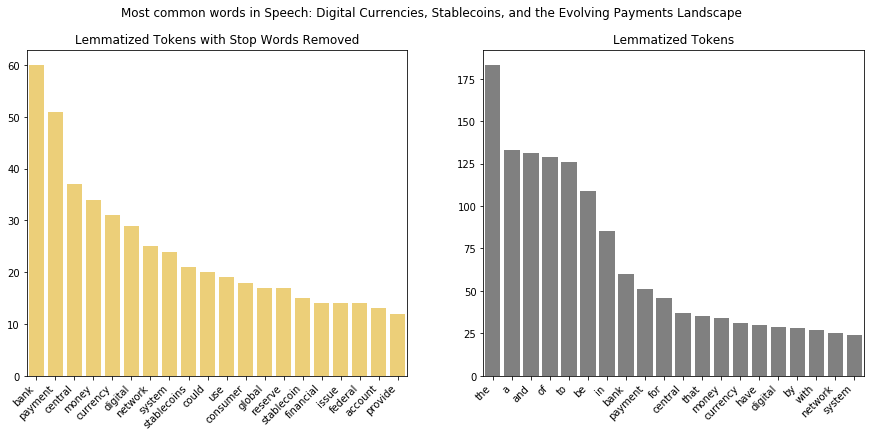

In [20]:
# Visual example of stop word removal, based on 20 most common words in the speech
# Shows us that our lemmatization and stop word removal worked well
plot_most_common_words(df, article_num=9)

In [42]:
# Converting speech_date columns to datetime
# and extracting month and year columns
df = convert_to_datetime(df)

In [27]:
# Obtaining speech polarity and subjectivity
df['polarity'] = df['full_text'].apply(lambda x: TextBlob(x).polarity)
df['subjectivity'] = df['full_text'].apply(lambda x: TextBlob(x).subjectivity)

In [28]:
# Sample of data cleaning results & new 
df[['title', 'lemm', 'speech_datetime', 'speech_year', 'speech_month', 'unique_lemm_words', 'common_20_lemm_words',
    'stopped_lemm_words', 'common_20_stopped_lemm_words', 'polarity', 'subjectivity']].head(3)

,title,lemm,speech_datetime,speech_year,speech_month,unique_lemm_words,common_20_lemm_words,stopped_lemm_words,common_20_stopped_lemm_words,polarity,subjectivity
0,The Federal Reserve’s Review of Its Monetary P...,"[i, be, delighted, to, be, at, the, cato, inst...",2019-11-14,2019,11,597,"[(the, 152), (and, 74), (be, 64), (to, 63), (o...","[delighted, cato, institute, today, participat...","[(policy, 29), (inflation, 27), (review, 23), ...",0.117149,0.410959
1,Brief Remarks (via pre-recorded video),"[vice, chair, for, supervision, quarles, brief...",2019-11-14,2019,11,417,"[(the, 98), (of, 43), (and, 41), (be, 39), (to...","[vice, chair, supervision, quarles, brief, rem...","[(financial, 18), (fsb, 17), (iais, 13), (insu...",0.094762,0.312060
2,"Monetary Policy, Price Stability, and Equilibr...","[good, morning, i, be, honor, and, delighted, ...",2019-11-12,2019,11,811,"[(the, 290), (and, 134), (in, 133), (of, 117),...","[good, morning, honor, delighted, participate,...","[(inflation, 83), (bond, 40), (policy, 39), (r...",0.062778,0.397190


In [29]:
# Save to pickle - so we don't need to re-run text cleaning functions
df.to_pickle('frb_speeches_all_clean.pkl')

# Feature Engineering

I create the dictionary and bag-of-words (bow) that will be used to run the NLP analysis.

In [2]:
#importing pandas DataFrame of speech text and metadata
df = pd.read_pickle('frb_speeches_all_clean.pkl')

In [3]:
# creating the dictionary
dictionary = create_dictionary(df, 'stopped_lemm_words', no_below=10, no_above=0.66, keep_n=10000)
# creating the bag of words - count of all words in the dictionary that appear in each document
bow_corpus = create_bow(df, dictionary, 'stopped_lemm_words')

Number of words in dictionary prior to filtering: 21483
Number of words in dictionary after filtering: 6711


# LDA Modeling

To proceed with topic modeling, I need to first identify the ideal number of topics for our corpus. I will use perplexity scores and coherence scores calculated on a number of topics to try and identify the ideal number of topics.

In [4]:
# Note: Fitting an LDA model and calculating the perplexity and coherence scores takes a while.
# Expect this gridsearch to take at least 5 minutes per iteration (num iterations = num topics)
scores = get_scores(bow_corpus,
                    dictionary,
                    df,
                    col_name='stopped_lemm_words',
                    min_num_topics = 2,
                    max_num_topics = 20)

In [ ]:
## Plot scores

In [22]:
# perplexity score of final model
per_score = lda_model.log_perplexity(bow_corpus)
print(per_score)

-7.384844951368197

In [23]:
# coherence score of final model
co_score = CoherenceModel(model=lda_model, texts=df['stopped_lemm_words'], dictionary=dictionary,
                                     coherence='c_v').get_coherence()
print(co_score)

0.5720122536905804

In [19]:
lda_model, df_dominant = run_and_save_final_lda_model(bow_corpus, 
                                                      dictionary, df, 
                                                      'stopped_lemm_words', 
                                                      num_topics = 11)

/Users/kathringo/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [21]:
df_dominant.head()

,Document_No,Dominant_Topic,Top_Topic_Perc_Contrib,Keywords
0,0,6.0,0.9771,"inflation, monetary, central, target, fomc, ex..."
1,1,3.0,0.5714,"firm, crisis, stress, requirement, regulatory,..."
2,2,6.0,0.8805,"inflation, monetary, central, target, fomc, ex..."
3,3,4.0,0.2956,"household, mortgage, debt, equity, loan, stock..."
4,4,6.0,0.3543,"inflation, monetary, central, target, fomc, ex..."


# Exploratory Data Analysis (EDA)

## Sentiment Analysis by Year of Speech

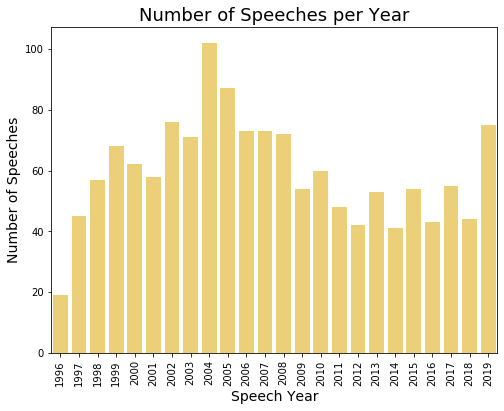

In [32]:
plot_speeches_per_year(df)

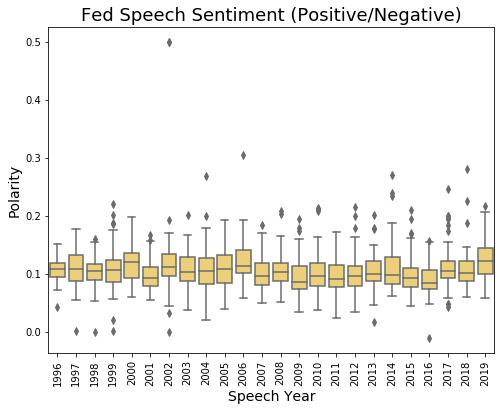

In [37]:
# Polarity (aka Sentiment) goes from 0 to 1
# We can see that most speeches are in a tight range of midly positive
plot_polarity_dist_per_year(df)

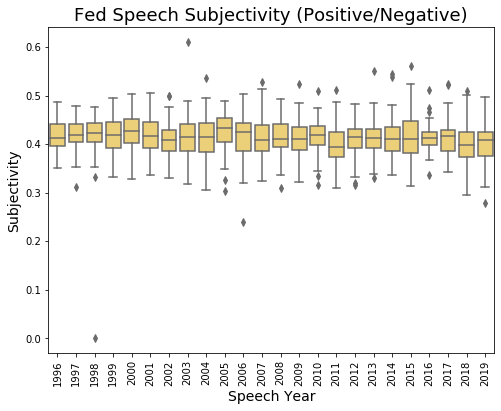

In [42]:
# Subjectivity goes from 0 to 1
# We can see that most speeches are in a tight range of somewhat subjective, somewhat emotional
plot_subjectivity_dist_per_year(df)